# Building explicit uncertainty dataset

In this notebook, we demonstrate how to quantify explicit uncertainty in the Lunguage dataset. We assume you have loaded in `Lunguage.csv` and `Lunguage_vocab.csv` in the `lunguage` folder, from the Physionet project "Lunguage: A Benchmark for Structured and Sequential Chest X-ray Interpretation".

We follow the pipeline shown below. 

![Explicit uncertainty pipeline](../figures/explicit_uncertainty_overview.png)

Strategy for assigning probabilities to finding–sentence pairs with tentative certainty in the Lunguage dataset: 
1. We first build a vocabulary of common hedging phrases and the sentences in which these are used. 
2. We further leverage LLMs to construct a reference ranking of these phrases, by performing pairwise comparisons of examples sentences 
3. Each finding–sentence pair is then compared against this reference, and
4. is finally mapped to a probability. 

This approach ensures that the probability assigned to each finding reflects not only the hedging phrase itself but also the broader context in which it appears.

By applying this process to the Lunguage dataset, we get a version that is expanded with probabilities for every finding-sentence pair.This dataset is stored in `data_resources/Lunguage_w_prob.csv`. 

Before running the code below, please create your environment via `conda env create -f requirements.yml`

## 1. Extracting a vocabulary of common hedging phrases

We use Gemini to extract hedging phrases for each finding-sentence pair in the Lunguage dataset. In `modules/extract_hedging_phrases.py`, we provide the code to extract hedging phrases for the whole Lunguage dataset. The resulting extracted phrases can be found in `data_resources/hedging_phrase_extracted.jsonl`. 

Below, we demonstrate the prompt on one finding-sentence pair example. To run the code, you must insert your own Google Vertex AI project identifier and authenticate via the command line. 

In [2]:
from modules import extract_hedging_phrases
from google import genai
client = genai.Client(
        vertexai=True,
        project="your-project-here",
        location="global",
    )

In [ ]:
entity = "pneumonia"
sentence = "possible early developing right middle lobe pneumonia"
user_prompt, system_prompt, response = extract_hedging_phrases.prompt_gemini_uncertainty_phrases(entity, sentence, client)

In [ ]:
print(system_prompt)

You are a radiologist who is given pairs of entities and sentences. Each entity appears in the corresponding sentence. 
Your task is to identify and extract only the words or phrases in the sentence that express uncertainty specifically about the given entity.


In [ ]:
print(user_prompt)

TASK: You are given pairs of entities and sentences. Each entity appears in the corresponding sentence. 
Your task is to identify and extract only the words or phrases in the sentence that express uncertainty specifically about the given entity.

Important notes:
- The sentence may mention multiple entities, but you should extract uncertainty clues only for the specified entity. Please refer to the examples below that show how you should handle such cases.
- Look for words or phrases that suggest uncertainty, speculation, approximation, possibility, or lack of definitiveness (e.g., "might", "possibly", "suggests", "appears to", "in some cases").
- Return a list of such uncertainty clues found in the sentence and relevant to the query entity.

Return your output as a list: ["<word or phrase 1>", "<word or phrase 2>", ...] 
If there are no uncertainty clues related to the given entity, return an empty list.

Below are 10 examples, after which you must complete the task for an unseen quer

In [ ]:
print(response)

["possible"]


After extracting these hedging phrases for the full Lunguage dataset, we do some processing based on other columns in Lunguage, to ensure that words which do not reflect certainty but rather other properties are filtered out. We also only include the sections "findings" and "impression", not history. This results in our vocabulary of 42 common hedging phrases. 

In [ ]:
import pandas as pd
import re
df = pd.read_json("../data_resources/hedging_phrase_extracted.jsonl", lines=True).set_index("idx")

def filter_unrelated_phrases(df, col_name): 
    # read in the gold dataset
    gold_dataset_path = '../data_resources/lunguage/Lunguage.csv'
    df_gold = pd.read_csv(gold_dataset_path)
    df_tent = df_gold[df_gold["dx_certainty"] == "tentative"].copy()
    print(f"{len(df_tent)} tentative entries, {len(df)} entries with extracted phrases")

    # match with the extracted phrases
    df_tent[col_name] = df[col_name]
    
    # remove phrases which are present in critical columns that usually do not reflect uncertainty levels
    check_cols_word_level = ["measurement", "severity", "onset"]
    def phrase_in_row(row):
        phrases = row[col_name]
        remove_phrase = ["difficult to assess"]
        for phrase in phrases:
            for col in check_cols_word_level: 
                if phrase not in ["or", "to"]: # don't do this for phrase "or", since too high chance that is part of a word
                    col_val = row[col] if not isinstance(row[col], float) else ""
                    pattern = r'\b' + r'\s+'.join(re.escape(word) for word in phrase.split()) + r'\b' # check if phrase is mentioned somewhere in column
                    if re.search(pattern, col_val, flags=re.IGNORECASE):
                        remove_phrase.append(phrase)
        return [phrase for phrase in phrases if phrase not in remove_phrase]
    
    # apply the filtering function
    df_tent["phrases_filt"] = df_tent.apply(phrase_in_row, axis=1)

    # add filtered phrases to original phrase df
    df["phrases_filt"] = df_tent["phrases_filt"]

    return df

df = filter_unrelated_phrases(df, "resp_list")
nr_filt = len(df[df['resp_list'] != df['phrases_filt']])
print(f"filter out {nr_filt} phrases due to their mention in severity, measurement, or onset column")

2508 tentative entries, 2508 entries with extracted phrases
filter out 22 phrases due to their mention in severity, measurement, or onset column


C:\Users\Administrator\AppData\Local\Temp\ipykernel_13892\1015357520.py:8: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_gold = pd.read_csv(gold_dataset_path)


In [ ]:
from collections import Counter, defaultdict

# filter out the history section
df_subset = df[df["section"] != "hist"]

# get all phrases
phrases = list(phrase for sublist in df_subset['phrases_filt'] for phrase in sublist)

# Count the frequency of each uncertainty word
word_counts = Counter(phrases)

# Get the 50 most common words
vocab = [phrase for phrase, count in word_counts.items() if count >= 10]

# Make a dictionary with sentences where these vocab words are found
vocab_sentences = defaultdict(list)
for _, row in df_subset.iterrows():
    sentence = row['sentence']
    phrases = row['phrases_filt']
    entity = row['entity_name']
    for phrase in phrases:
        if phrase in vocab:
            vocab_sentences[phrase].append({
                "sentence": sentence, 
                "entity": entity
            })

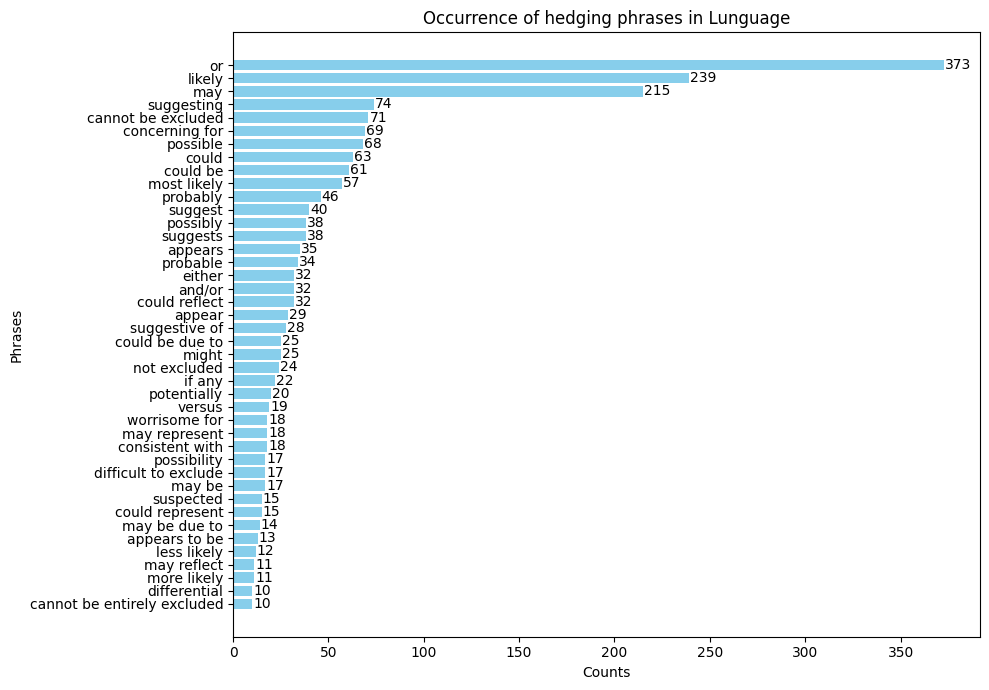

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Step 1: Filter and sort by count (descending)
filtered_counts = Counter({phrase: count for phrase, count in word_counts.items() if count >= 10})
sorted_counts = filtered_counts.most_common()  # Sorts descending by default

phrases, counts = zip(*sorted_counts)  # Unpack into two lists

# Step 2: Plot horizontal bar chart
plt.figure(figsize=(10, 7))
bars = plt.barh(phrases, counts, color='skyblue')
plt.xlabel('Counts')
plt.ylabel('Phrases')
# plt.title('Vocabulary of uncertainty phrases')
plt.gca().invert_yaxis()  # Highest count on top

# Step 3: Add counts to the end of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2,
             str(int(width)), va='center')

plt.title("Occurrence of hedging phrases in Lunguage")
plt.tight_layout()
plt.show()


The file `hedging_phrase_vocab.json` contains our vocabulary of 42 hedging phrases, accompanied by all the finding-sentence pairs in Lunguage where they've been extracted. 

## 2. Building a reference ranking of hedging phrases

We now use the TrueSkill algorithm to build a ranking of our vocabulary of 42 common hedging phrases. This algorithm needs a set of pairwise comparisons at the input, where pairs of phrases are pitched against each other. Every pair of hedging phrases (861 pairs) are compared 10 times, each time sampling another random set of example sentences where the phrase is used, masking out the particular finding to make the compparison more neutral. We use LLMs to choose the phrase that is closest to "finding is certainly present". In ``modules/compare_hedging_phrases.py`` we provide code to prompt 4 LLMs to perform these comparisons: 
- GPT-4o
- Claude
- Gemini
- MedGemma

To run this file, you should fill in your own project names and API keys for all four LLMs. Running this file for all pairs of hedging phrases and all LLMs results in the files `data_resources/hedging_phrase_comparisons/comparisons_{LLM}.jsonl`, where every row stores the phrases that were compared, the particular sentences that were sampled, the findings that were masked out of that sentence ("<finding>"), and the winning phrase. 

Below, we show an example of performing one comparison with Gemini.


In [ ]:
from modules.compare_hedging_phrases import LLMSentenceComparer

llm_prompter = LLMSentenceComparer(gemini_project="your-project-here")

sentence1 = "possible early developing right middle lobe <finding>"
sentence2 = "lungs are hyperinflated suggesting present <finding>"
prompt, response, cost = llm_prompter.compare_sentences(sentence1, sentence2, "Gemini")

c:\Users\Administrator\anaconda3\envs\lunguage_uncertainty\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
print(prompt)

You will be given two sentences from radiology reports. Each sentence contains a placeholder "<finding>", which represents a medical observation (e.g., consolidation, effusion, nodule). Each sentence includes a phrase that expresses the degree of certainty about the presence or absence of the finding.
Assume there is a certainty spectrum ranging from:

    "<finding> is certainly absent"
    to
    "<finding> is certainly present"

Your task is to identify which sentence is **closer to "<finding> is certainly present"** on this scale, using the context of the sentence. 
In other words, your task is to identify which sentence expresses a higher degree of certainty that the finding is present.

Respond with **only** the chosen sentence (sentence_1 or sentence_2).

Here are some examples.

---

Example 1:
INPUT:
{
  "sentence_1": "interstitial markings are prominent, suggest possible mild <finding>.",
  "sentence_2": "allowing for low inspiratory volumes, the <finding> is probably unchang

In [ ]:
print(response)

sentence_2


In [ ]:
print(cost)

0.0001512


Once all comparisons have been made by all 4 LLMs, we construct a reference ranking of phrases using the Trueskill algorithm. The file `modules/ranking_algorithm.py` contains the `TrueSkillRanker` class, which automatically constructs a ranking of items based on a set of input matches between those items, where each match has a winner. It does this by keeping track of the skill level `mu` for each of those items, as well as a deviation `sigma` around the skill level. In our case, the items are the hedging phrases in our vocabulary, and the matches are the LLM-based comparisons of two random sentences where those phrases are mentioned. 

Below, we apply the TrueSkill algorithm 10 times (each with a different seed), and take the average `mu` and `sigma` to arrive at a final reference ranking of our hedging phrases. 

In [ ]:
from modules.ranking_algorithm import TrueSkillRanker
import numpy as np
import pandas as pd

def get_reference_ranking(): 

    # read in initial LLM comparisons (5 per phrase pair)
    df_comp = {}
    df_comp["gemini"] = pd.read_json("../data_resources/hedging_phrase_comparisons/comparisons_gemini.jsonl", lines=True)
    df_comp["gpt"] = pd.read_json("../data_resources/hedging_phrase_comparisons/comparisons_gpt.jsonl", lines=True)
    df_comp["medgemma"] = pd.read_json("../data_resources/hedging_phrase_comparisons/comparisons_medgemma.jsonl", lines=True)
    df_comp["claude"] = pd.read_json("../data_resources/hedging_phrase_comparisons/comparisons_claude.jsonl", lines=True)

    # merge them all into one dataframe
    merged_df = pd.concat(
        [df.assign(model=model_name) for model_name, df in df_comp.items()],
        ignore_index=True
    )

    # run trueskill for 10 seeds, each with different ordering
    total_ratings = {}
    merged_df["time"] = range(len(merged_df))

    for seed in [60, 93, 67, 92, 18, 68, 62, 33, 23, 78]:

        # shuffle time 
        np.random.seed(seed)
        shuffled_df = merged_df.copy()
        shuffled_df["time"] = np.random.permutation(merged_df["time"].values)

        # get ranking
        ranker = TrueSkillRanker()
        ranker.update_ratings_from_dataframe(shuffled_df)
        df_rank = ranker.get_ranking(conservative=False)

        total_ratings[seed] = df_rank

    # Group by phrase and compute mean mu and sigma across the seeds
    df_all_seeds = pd.concat(total_ratings.values(), ignore_index=True)
    avg_df = df_all_seeds.groupby('phrase')[['mu', 'sigma']].mean().reset_index()

    # Sort by rank
    ranking_df = avg_df.sort_values(by='mu', ascending=False)
    ranking_df.reset_index(inplace=True, drop=True)
    ranking_df["rank"] = ranking_df.index
    ranking_df.set_index("phrase", inplace=True)

    return ranking_df.reset_index()

In [ ]:
ref_ranking = get_reference_ranking()

In [ ]:
import matplotlib.pyplot as plt

def plot_ranking(ranking_df):
    # Sort by mu descending
    ranking_df = ranking_df.sort_values(by='mu', ascending=False)

    plt.figure(figsize=(8, 11))
    ax = plt.gca()  # get current axes

    # Plot horizontal bars
    bars = ax.barh(
        ranking_df['phrase'],
        ranking_df["mu"],
        xerr=ranking_df["sigma"],
        color='skyblue',
        ecolor='gray',
        capsize=5
    )

    # Invert y-axis
    ax.invert_yaxis()

    # Add rating numbers
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 1.5,
                bar.get_y() + bar.get_height() / 2,
                f'{width:.2f}',
                va='center')

    # Labels
    # ax.set_xlabel('Rating (μ)')

    # 🔹 Remove the outer box (spines)
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Optionally remove tick lines too
    ax.tick_params(left=False, bottom=False, labelbottom=False)

    plt.tight_layout()
    plt.show()


We visualize the reference ranking of hedging phrases. This final reference ranking can also be found in the file `data_resources/reference_ranking.csv`. 

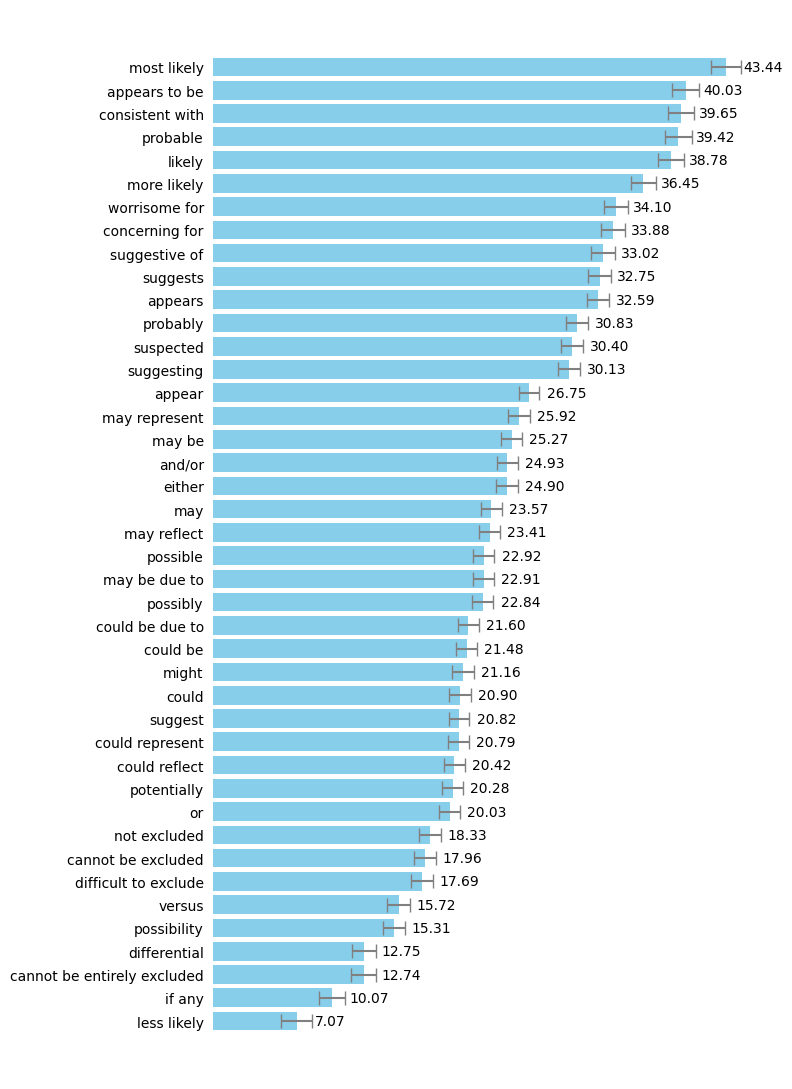

In [ ]:
plot_ranking(ref_ranking)

We validate the reference ranking and the LLM comparisons with an expert evaluation study. Experts were asked to compare 50 pairs of phrases, and to choose the phrase that is closest to "finding is certainly present", the results are found in `data_resources/evaluation_study/expert_phrase_comparisons.csv`. We can compare their opinion to the phrases in the reference ranking, and to the judgement of the LLMs. 

In [ ]:
import pandas as pd
df_ref = pd.read_csv("../data_resources/reference_ranking.csv", index_col=0)
df_expert = pd.read_csv("../data_resources/evaluation_study/expert_phrase_comparisons.csv", index_col=0)

In [ ]:
df_expert.head()

,question,phrase_1,phrase_2,response_1,response_2,response_3,response_4,response_5,response_6
0,Which term expresses a higher degree of certai...,could be due to,probable,probable,probable,probable,probable,probable,probable
1,Which term expresses a higher degree of certai...,appear,difficult to exclude,appear,appear,appear,appear,appear,appear
2,Which term expresses a higher degree of certai...,could reflect,differential,could reflect,could reflect,could reflect,could reflect,could reflect,could reflect
3,Which term expresses a higher degree of certai...,could be,likely,likely,likely,likely,likely,likely,likely
4,Which term expresses a higher degree of certai...,could,versus,could,could,versus,versus,could,could


The information about the 6 experts can be found in `data_resources/evaluation_study/expert_participant_info.csv`. 

In [ ]:
df_info = pd.read_csv("../data_resources/evaluation_study/expert_participant_info.csv", index_col=0)

In [ ]:
df_info

,question,response_1,response_2,response_3,response_4,response_5,response_6
0,What is your occupation?,Internal medicine,Radiologist,General practitioner,Radiologist,Board-certified radiation oncologist,General practitioner
1,How many years of experience do you have in th...,30 to 40 years,5 to 10 years,30 to 40 years,0 to 5 years,5 to 10 years,0 to 5 years


We now compare the experts with the reference ranking and with the LLM comparisons. For the LLM comparisons, 10 comparisons were done per LLM per phrase pair, so we take a majority vote across those 10 comparisons before comparing with the expert's judgment.

In [ ]:
import pandas as pd
import itertools

# --- Step 1. Load blueprint ranking into a dictionary for fast lookup ---
rank_dict = df_ref['rank'].to_dict()

# --- Step 2. Reshape df_expert into long format (one row per expert judgment) ---
long_df = df_expert.melt(
    id_vars=["phrase_1", "phrase_2"],
    value_vars=["response_1", "response_2", "response_3", "response_4", "response_5", "response_6"],
    var_name="expert",
    value_name="chosen"
)

# --- Step 3. Determine blueprint-preferred phrase for each pair ---
def blueprint_choice(row):
    r1 = rank_dict[row["phrase_1"]]
    r2 = rank_dict[row["phrase_2"]]
    if r1 < r2:
        return row["phrase_1"]
    elif r2 < r1:
        return row["phrase_2"]
    else:
        return None  # in case of ties

long_df["blueprint_choice"] = long_df.apply(blueprint_choice, axis=1)

# --- Step 4. Agreement ---
long_df["agreement"] = (long_df["chosen"] == long_df["blueprint_choice"])

# Overall proportion agreement
proportion_agreement = long_df["agreement"].mean()

# Per expert proportion agreement
per_expert_agreement = long_df.groupby("expert")["agreement"].mean()

In [ ]:
import pandas as pd
import random

# read in initial LLM comparisons (5 per phrase pair)
df_comp = {}
df_comp["gemini"] = pd.read_json("../data_resources/hedging_phrase_comparisons/comparisons_gemini.jsonl", lines=True)
df_comp["gpt"] = pd.read_json("../data_resources/hedging_phrase_comparisons/comparisons_gpt.jsonl", lines=True)
df_comp["medgemma"] = pd.read_json("../data_resources/hedging_phrase_comparisons/comparisons_medgemma.jsonl", lines=True)
df_comp["claude"] = pd.read_json("../data_resources/hedging_phrase_comparisons/comparisons_claude.jsonl", lines=True)

# merge them all into one dataframe
merged_df = pd.concat(
    [df.assign(model=model_name) for model_name, df in df_comp.items()],
    ignore_index=True
)

# Columns to match on
key_columns = ["phrase_1", "phrase_2", "sentence_1", "sentence_2", "entity_1", "entity_2"]

# Extract and rename chosen_phrase from each dataframe
renamed_dfs = []
for name, df in df_comp.items():
    renamed = df[key_columns + ["chosen_phrase"]].copy()
    renamed = renamed.rename(columns={"chosen_phrase": name})
    renamed_dfs.append(renamed)

# Sort by matching columns, then merge dfs (ensures one-on-one matching for every row)
merged_df = pd.concat([renamed_dfs[0].sort_values(by=key_columns).reset_index(drop=True), renamed_dfs[1].sort_values(by=key_columns).reset_index(drop=True).drop(columns=key_columns)], axis=1)
merged_df = pd.concat([merged_df, renamed_dfs[2].sort_values(by=key_columns).reset_index(drop=True).drop(columns=key_columns)], axis=1)
df_llm = pd.concat([merged_df, renamed_dfs[3].sort_values(by=key_columns).reset_index(drop=True).drop(columns=key_columns)], axis=1)

# Reorder phrases alphabetically for each row in df_llm
df_llm[['phrase_1', 'phrase_2']] = df_llm.apply(
    lambda x: sorted([x['phrase_1'], x['phrase_2']]),
    axis=1, result_type='expand'
)

# Create order-insensitive tuples by sorting the phrases in each pair
df_expert_pairs = df_expert[['phrase_1', 'phrase_2']].apply(lambda x: tuple(sorted(x)), axis=1)
df_llm_pairs = df_llm[['phrase_1', 'phrase_2']].apply(lambda x: tuple(sorted(x)), axis=1)

# Filter df_llm to keep only pairs that exist in df_expert (order-insensitive)
df_llm_filtered = df_llm[df_llm_pairs.isin(df_expert_pairs)].copy()

print(f"Original LLM rows: {len(df_llm)}, filtered rows: {len(df_llm_filtered)}")

# List of LLMs
llm_cols = ["gemini", "gpt", "medgemma", "claude"]
random.seed(42)

# Function to compute majority choice with tie handling
def majority_vote(series):
    counts = series.value_counts()
    if len(counts) == 0:
        return None
    if len(counts) > 1 and counts.iloc[0] == counts.iloc[1]:
        # Tie → randomly choose one of the tied options
        return random.choice(counts.index[:2])
    return counts.idxmax()

# New dataframe with one row per pair
df_llm_majority = (
    df_llm_filtered.groupby(["phrase_1", "phrase_2"])
    [llm_cols].agg(lambda col: majority_vote(col))
    .reset_index()
)

df_llm_majority.head()

Original LLM rows: 8610, filtered rows: 500


,phrase_1,phrase_2,gemini,gpt,medgemma,claude
0,and/or,could be due to,and/or,and/or,and/or,and/or
1,and/or,could reflect,and/or,and/or,and/or,and/or
2,and/or,differential,and/or,and/or,and/or,and/or
3,and/or,may reflect,and/or,and/or,may reflect,and/or
4,appear,differential,appear,appear,appear,appear


In [ ]:
# --- Step 1: Select experts ---
expert_cols = ["response_1", "response_2", "response_3", "response_4", "response_5", "response_6"]

# --- Step 2: Merge LLM and expert data ---
df_compare = df_llm_majority.merge(
    df_expert[["phrase_1", "phrase_2"] + expert_cols],
    on=["phrase_1", "phrase_2"],
    how="inner"
)

# --- Step 3: Encode preference function ---
def encode_pref(row, col):
    return 1 if row[col] == row["phrase_1"] else -1

# --- Step 4: Loop over LLMs and experts ---
llm_cols = ["gemini", "gpt", "medgemma", "claude"]
results = []

for llm in llm_cols:
    for expert in expert_cols:
        # Agreement
        agreement = (df_compare[llm] == df_compare[expert]).mean()

        # Encode preferences
        llm_pref = df_compare.apply(lambda x: encode_pref(x, llm), axis=1)
        expert_pref = df_compare.apply(lambda x: encode_pref(x, expert), axis=1)

        results.append({
            "LLM": llm,
            "Expert": expert,
            "Agreement": agreement
        })

df_llm_vs_expert = pd.DataFrame(results)

# --- Step 5: Pretty pivot tables ---
agreement_table = df_llm_vs_expert.pivot(index="LLM", columns="Expert", values="Agreement")
new_order = ["response_2", "response_4", "response_1", "response_5", "response_3", "response_6"]
agreement_table_reordered = agreement_table[new_order]
new_order = ["gemini", "gpt", "claude", "medgemma"]
agreement_table_reordered = agreement_table_reordered.loc[new_order].transpose()

# --- Step 6: Add in agreement with reference ---
agreement_table_reordered["reference"] = per_expert_agreement

# --- Step 7: Rename the rows according to occupation ---
df_agreement = agreement_table_reordered.rename(index={"response_2": "Radiologist", "response_4": "Radiologist", "response_1": "Internist",
                                                        "response_5": "Oncologist", "response_3": "GP", "response_6": "GP"})

In [ ]:
df_agreement

LLM,gemini,gpt,claude,medgemma,reference
Expert,,,,,
Radiologist,0.80,0.82,0.72,0.84,0.80
Radiologist,0.76,0.82,0.76,0.80,0.80
Internist,0.86,0.88,0.82,0.90,0.86
Oncologist,0.68,0.74,0.76,0.72,0.72
GP,0.70,0.68,0.66,0.62,0.66
GP,0.82,0.84,0.78,0.82,0.82


## 3. Ranking each finding-sentence pair based on the reference ranking

Now that the reference ranking has been established, we want to fit each of the finding-sentence pairs from the tentative lunguage dataset into this ranking. The resulting mu value then represents the amount of (un)certainty associated with the finding, which can be mapped onto a probability in the next step. 

The algorithm code can be found in `modules/ranking_algorithm.py`, and the results in `data_resources/rank_sentence_log.jsonl`. For every finidng-sentence pair in the tentative portion of Lunguage, this file contains the index ("idx") of that pair in `data_resources/resources/Lunguage.csv`, the finding name ("entity"), the sentence, the final rank (between 0 and 43), the final mu ("score") and sigma, the cost for ranking this sentence, and the number of steps it took to reach this score. 

When a sentence is ranked, a log file of all LLM calls is stored in `data_resources/ranking_log/llm_logs/` and a log file of the ranking process is stored in `data_resources/ranking_log/ranker_logs/`. 

We show one example of how to rank a finding-sentence pair from Lunguage. 

In [ ]:
from modules.ranking_algorithm import SentenceRanker
from modules.compare_hedging_phrases import LLMSentenceComparer
import pandas as pd
import json

finding = "prominence"
sentence = "cardiac and mediastinal silhouettes are stable with possible slight decrease in right paratracheal prominence."

# read reference ranking and vocab
reference = pd.read_csv("../data_resources/reference_ranking.csv")
reference.set_index("phrase", inplace=True)
with open("../data_resources/hedging_phrase_vocab.json", 'r', encoding='utf-8') as f:
    vocab = json.load(f)

# initialize LLM object 
gemini_project="your-gemini-project-here"
openai_endpoint="your-azure-openai-endpoint-here"
openai_key="your-azure-openai-key-here"
anthropic_key="your-anthropic-key-here"
huggingface_token="your-huggingface-token-here"
llm_sent_comparer = LLMSentenceComparer(gemini_project, openai_endpoint, openai_key, anthropic_key, huggingface_token)

# mask <finding> in candidate sentence
masked_sentence = sentence.replace(finding, "<finding>")

# initialize sentence ranker
max_steps = 100
max_plays = 5
all_llms_cutoff = 10
patience = 10
run_seed = 42
llm_log_path = f"../data_resources/ranking_log/llm_logs/example.jsonl"
sent_ranker = SentenceRanker(reference, vocab, llm_sent_comparer, llm_log_path, max_steps, max_plays, patience, all_llms_cutoff, seed=run_seed)

# rank candidate sentence
logs, rank = sent_ranker.rank_unseen_sentence(masked_sentence)

# store logs as csv
logs.to_csv(f"../data_resources/ranking_log/ranker_logs/example.csv", index=False)

After ranking a sentence, we can inspect the different steps in the algorithm through the ranking logs. The following information is stored:
- step
- opponent: the opponent phrase against which the sentence is compared
- draw_prob: the draw probability of that opponent
- winner: the winner of the comparison
- rank_sent: the rank of the sentence afer this game is played
- rank_opp: the rank of the opponent after this game is played
- score_sent: the mu score of the sentence after this game is played
- sigma_sent: the sigma of this sentence after this game is played
- cost: the cost of calling the LLM(s) for this comparison
- llm_name: the LLM that is used to make this comparison. "all" means that all 4 LLMs are prompted.

In [ ]:
ranker_log_df = pd.read_csv("../data_resources/ranking_log/ranker_logs/example.csv")

In [6]:
ranker_log_df

,step,opponent,draw_prob,winner,rank_sent,rank_opp,score_sent,sigma_sent,cost,llm_name
0,0,and/or,0.575086,"['and/or', 'and/or', 'and/or', 'and/or']",37,17,15.522268,4.599067,0.003289,all
1,1,versus,0.781518,"['versus', 'SENT', 'SENT', 'versus']",37,36,15.651048,2.984599,0.003242,all
2,2,versus,0.882626,"['versus', 'SENT', 'versus', 'versus']",38,36,14.157127,2.369309,0.003246,all
3,3,possibility,0.902487,"['SENT', 'SENT', 'SENT', 'SENT']",36,38,16.683741,2.019666,0.003318,all
4,4,versus,0.923965,"['versus', 'SENT', 'versus', 'versus']",37,36,15.606166,1.785741,0.003238,all
5,5,versus,0.945254,"['versus', 'versus', 'versus', 'SENT']",38,36,14.922649,1.623653,0.003290,all
6,6,possibility,0.950288,"['possibility', 'SENT', 'SENT', 'SENT']",37,38,15.589529,1.498848,0.003361,all
7,7,versus,0.956875,"['versus', 'SENT', 'SENT', 'versus']",37,36,15.607905,1.400975,0.003248,all
8,8,possibility,0.959538,"['SENT', 'SENT', 'SENT', 'SENT']",36,38,16.510280,1.325661,0.003223,all
9,9,difficult to exclude,0.946603,"['difficult to exclude', 'SENT', 'SENT', 'SENT']",36,35,17.070723,1.258147,0.003276,all


In [7]:
llm_log_df = pd.read_json("../data_resources/ranking_log/llm_logs/example.jsonl", lines=True)

We can also inspect the LLM calls that were made through the LLM logs. In the dataframe below, we store, for every LLM call: 
- step: the step in which this call was made. note that, for the first 10 steps, all 4 LLMs are called
- llm_name: name of the LLM (GPT, Gemini, Claude, MedGemma)
- sentence: the sentence we are ranking
- opp: the selected opponent phrase (corresponds to "opponent" in the rank_log_df)
- opp_sentence: the opponent sentence against which the sentence is played (a sentence where the opp hedging phrase is mentioned, randomly sampled from the vocabulary)
- winner: the winner of the comparison as chosen by the LLM (sentence_1 or sentence_2)
- cost: the estimated cost of this LLM call

In [8]:
llm_log_df

,step,llm_name,sentence,opp_sentence,opp,winner,cost
0,0,GPT,cardiac and mediastinal silhouettes are stable...,there is some blunting of the left costophreni...,and/or,sentence_2,0.001414
1,0,Gemini,cardiac and mediastinal silhouettes are stable...,1 small left effusion with underlying collapse...,and/or,sentence_2,0.000157
2,0,Claude,cardiac and mediastinal silhouettes are stable...,relative enlargement of the cardiac silhouette...,and/or,sentence_2,0.001719
3,0,MedGemma,cardiac and mediastinal silhouettes are stable...,increased opacity at left lung base is either ...,and/or,sentence_2,0.000000
4,1,GPT,cardiac and mediastinal silhouettes are stable...,linear patchy at the right lung base is compat...,versus,sentence_2,0.001386
...,...,...,...,...,...,...,...
69,39,Gemini,cardiac and mediastinal silhouettes are stable...,persistent probable left lower lobe posterior ...,could represent,sentence_1,0.000160
70,40,MedGemma,cardiac and mediastinal silhouettes are stable...,an area of focal opacity projected over the le...,could represent,sentence_2,0.000000
71,41,MedGemma,cardiac and mediastinal silhouettes are stable...,persistent probable left lower lobe posterior ...,could represent,sentence_2,0.000000
72,42,Gemini,cardiac and mediastinal silhouettes are stable...,lower lung opacities which could represent <fi...,could represent,sentence_1,0.000162


## 4. Map to probability scale

Now that we have the score mu for every sentence in the tentative Lunguage dataset, we can map it to a probability. This is done by a sigmoid mapping. The anchor points (`u_lo = 0.170` and `u_hi = 0.839`), probabilities corresponding to the phrase "most likely" and "less likely" in the reference ranking, are set by two radiologists. 

In [1]:
import pandas as pd
df_ref = pd.read_csv("../data_resources/reference_ranking.csv")

In [2]:
import numpy as np
class UncertaintyMapping:
    
    def __init__(self, blueprint, u_lo=0.3, u_hi=0.8):
        """
        Fit sigmoid parameters x0 and k using two known (mu, uncertainty) pairs.
        Assumes output is in (0, 1).
        """
        # Avoid 0 or 1 which cause logit to explode
        eps = 1e-6
        self.u_lo = np.clip(u_lo, eps, 1 - eps)
        self.u_hi = np.clip(u_hi, eps, 1 - eps)
        self.mu_hi = blueprint['mu'].max()    # highest rank (top phrase)
        self.mu_lo = blueprint['mu'].min()    # lowest rank (bottom phrase)

        logit_lo = np.log(u_lo / (1 - u_lo))
        logit_hi = np.log(u_hi / (1 - u_hi))

        # Solve for k and x0
        self.k = (logit_hi - logit_lo) / (self.mu_hi - self.mu_lo)
        self.x0 = self.mu_hi - logit_hi / self.k

    def mu_to_uncertainty(self, mu):
        unc = 1 / (1 + np.exp(-self.k * (mu - self.x0)))
        if unc < 0:
            return 0
        if unc > 1: 
            return 1
        return unc

We demonstrate the mapping on the reference ranking. 

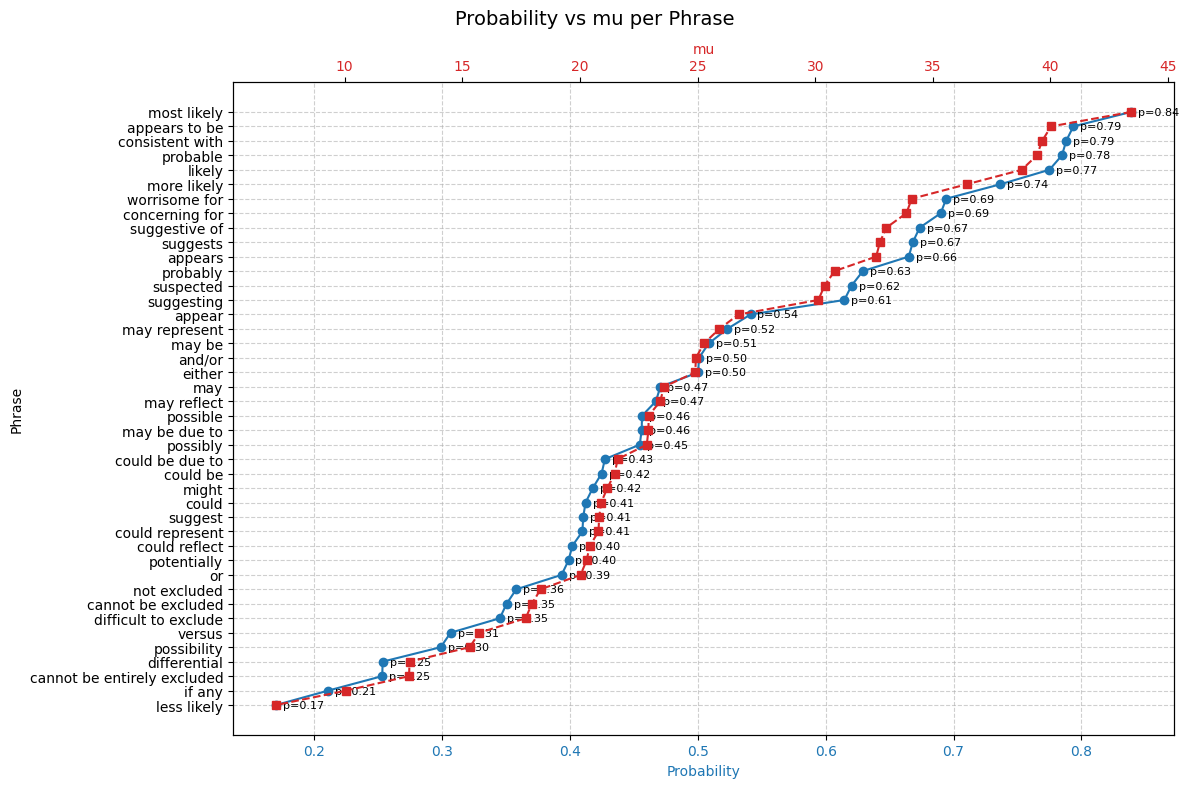

In [3]:
import matplotlib.pyplot as plt

# Initialize the mapper
mapper = UncertaintyMapping(df_ref, u_lo=0.17, u_hi=0.839)

# Apply mu_to_uncertainty
df_ref['uncertainty'] = df_ref['mu'].apply(mapper.mu_to_uncertainty)

# Create figure
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot uncertainty on bottom x-axis
ax1.plot(df_ref['uncertainty'], df_ref['phrase'], 'o-', color='tab:blue', label='Probability')
ax1.set_ylabel("Phrase")
ax1.set_xlabel("Probability", color='tab:blue')
ax1.tick_params(axis='x', labelcolor='tab:blue')

# Create twin axis for mu on top x-axis
ax2 = ax1.twiny()
ax2.plot(df_ref['mu'], df_ref['phrase'], 's--', color='tab:red', label='mu')
ax2.set_xlabel("mu", color='tab:red')
ax2.tick_params(axis='x', labelcolor='tab:red')

# Annotate each point with uncertainty & mu
for i, row in df_ref.iterrows():
    ax1.annotate(
        f"p={row['uncertainty']:.2f}",
        (row['uncertainty'], row['phrase']),
        textcoords="offset points",
        xytext=(5, 0),
        ha='left',
        va='center',
        fontsize=8,
        color="black"
    )

# Add grid + title
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.invert_yaxis()
fig.suptitle("Probability vs mu per Phrase", fontsize=14)

plt.tight_layout()
plt.show()


We can now assign a probability to each of the finding-sentence pairs in Lunguage. We use the following rules: 
- if `dx_certainty = definitive` and `dx_status = positive`, then we assign a probability of `prob = 1.0`
- if `dx_certainty = definitive` and `dx_status = negative`, then we assign a probability of `prob = 0.0`
- if `dx_certainty = tentative`, the we disregard `dx_status`, and assign `prob = UncertaintyMapping.mu_to_uncertainty(mu)` based on the final `mu` achieved by applying the SentenceRanker from step 3. 

In [4]:
# load in Lunguage dataset, no history
df_lung = pd.read_csv("../data_resources/lunguage/Lunguage.csv", index_col=0)
df_lung = df_lung[df_lung["section"] != "hist"]

# load in mu for every tentative sentence, map to probability using Sigmoid mapping function
res_df = pd.read_json("../data_resources/ranking_log/rank_sentence_log.jsonl", lines=True)
df_lung["score"] = df_lung.index.map(res_df.set_index("idx")["score"])
df_lung["prob"] = df_lung["score"].apply(mapper.mu_to_uncertainty)

# set probability for definitive cases
df_lung.loc[(df_lung["dx_status"] == "positive") & (df_lung["dx_certainty"] == "definitive"), "prob"] = 1.0
df_lung.loc[(df_lung["dx_status"] == "negative") & (df_lung["dx_certainty"] == "definitive"), "prob"] = 0.0

C:\Users\Administrator\AppData\Local\Temp\ipykernel_31236\490558958.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_lung = pd.read_csv("../data_resources/lunguage/Lunguage.csv", index_col=0)


In [ ]:
df_lung[df_lung["dx_certainty"] == "tentative"][["ent", "sent", "score", "prob"]].head()

,ent,sent,score,prob
64,prominence,cardiac and mediastinal silhouettes are stable...,18.217656,0.355798
66,pneumonia,no radiographic findings to suggest pneumonia.,0.407298,0.101676
79,perihilar edema,crowding of the pulmonary vasculature with pos...,18.885586,0.369537
80,pulmonary edema,crowding of the pulmonary vasculature with pos...,4.953686,0.145031
97,pneumonia,"given the clinical presentation, pneumonia mus...",25.229338,0.507593


In [8]:
df_lung[df_lung["dx_certainty"] == "definitive"][["ent", "sent", "dx_status", "score", "prob"]].head()

,ent,sent,dx_status,score,prob
1,tip,ap chest compared to : tip of the endotracheal...,positive,NaN,1.0
2,tip,ap chest compared to : tip of the endotracheal...,positive,NaN,1.0
3,lungs,lungs are clear.,negative,NaN,0.0
4,cardiomediastinal silhouettes,cardiomediastinal and hilar silhouettes and pl...,negative,NaN,0.0
5,hilar silhouettes,cardiomediastinal and hilar silhouettes and pl...,negative,NaN,0.0


This dataframe is stored in `data_resources/Lunguage_w_prob.csv`. 